# Mall Customers: K-means vs Hierarchical Clustering

**Assignment:** Group 1 - Mall Customers Dataset (100 points)

**Objective:** Compare K-means and Hierarchical clustering on customer data to identify meaningful customer segments for business insights.

This analysis will help us understand different types of mall customers based on their demographics and spending patterns, which can inform targeted marketing strategies and customer relationship management.

In [1]:
# Import all necessary libraries for our clustering analysis
import pandas as pd                    # Data manipulation and analysis
import numpy as np                     # Numerical computing
import matplotlib.pyplot as plt        # Basic plotting
import seaborn as sns                  # Statistical visualizations

# Clustering algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Evaluation metrics for clustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Hierarchical clustering tools
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist

# Statistical testing
from scipy.stats import f_oneway, kruskal, chi2_contingency

import warnings
warnings.filterwarnings('ignore')     # Hide warning messages for cleaner output

# Set random seed for reproducible results
np.random.seed(42)
print("Libraries imported successfully")

Libraries imported successfully


## Part A: Data Loading & Preprocessing (15 points)

Now we'll load our Mall Customers dataset and get it ready for analysis. This step is crucial because clean, well-prepared data leads to more reliable clustering results. We'll examine the structure, handle any data quality issues, and prepare our features for clustering algorithms.

In [2]:
# Load the Mall Customers dataset
try:
    # First, try to load the actual dataset file
    df = pd.read_csv('Mall_Customers.csv')
    print("✅ Dataset loaded successfully from Mall_Customers.csv")
except:
    # If file not found, create realistic sample data for demonstration
    print("⚠️ Mall_Customers.csv not found. Creating sample dataset...")
    np.random.seed(42)  # Ensure reproducible sample data
    
    # Generate 200 sample customers with realistic distributions
    df = pd.DataFrame({
        'CustomerID': range(1, 201),                                    # Unique customer identifiers
        'Gender': np.random.choice(['Male', 'Female'], 200),           # Random gender distribution
        'Age': np.random.randint(18, 70, 200),                        # Ages between 18-70
        'Annual Income (k$)': np.random.randint(15, 137, 200),        # Income 15k-137k range
        'Spending Score (1-100)': np.random.randint(1, 101, 200)      # Spending scores 1-100
    })
    print("📊 Sample dataset created with 200 customers")

# Display basic dataset information
print(f"\n📈 Dataset shape: {df.shape[0]} rows × {df.shape[1]} columns")

# Show first 10 rows as required
print("\n🔍 First 10 rows of the dataset:")
print(df.head(10))

# Identify and display column data types
print("\n🏷️ Data types for each column:")
print(df.dtypes)

✅ Dataset loaded successfully from Mall_Customers.csv

📈 Dataset shape: 200 rows × 5 columns

🔍 First 10 rows of the dataset:
   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
5           6  Female   22                  17                      76
6           7  Female   35                  18                       6
7           8  Female   23                  18                      94
8           9    Male   64                  19                       3
9          10  Female   30                  19                      72

🏷️ Data types for each column:
CustomerID                 int64
Genre                     ob

In [7]:
# Step 1: Check for and remove exact duplicate rows
print("🔍 Checking for duplicate rows...")
initial_rows = len(df)
duplicate_count = df.duplicated().sum()

print(f"Duplicate rows found: {duplicate_count}")
df = df.drop_duplicates()                          # Remove any duplicate entries
rows_after_dedup = len(df)
print(f"Rows after removing duplicates: {rows_after_dedup}")
print(f"Rows removed: {initial_rows - rows_after_dedup}")

# Step 2: Identify and handle missing values
print(f"\n🔍 Checking for missing values...")
missing_summary = df.isnull().sum()
print(f"Missing values per column:\n{missing_summary}")

# Remove rows with more than 50% missing fields (as per assignment requirements)
threshold = len(df.columns) * 0.5                 # 50% of columns
rows_before_missing = len(df)
df = df.dropna(thresh=threshold)                   # Keep rows with at least 50% non-missing
rows_after_threshold = len(df)

print(f"\nRows before missing value handling: {rows_before_missing}")
print(f"Rows after removing high-missing rows: {rows_after_threshold}")
print(f"Rows removed for >50% missing: {rows_before_missing - rows_after_threshold}")

# Impute remaining missing values using appropriate strategies
# For numeric columns: use median (robust to outliers)
for col in df.select_dtypes(include=[np.number]).columns:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"  Imputed {col} with median: {median_val}")

# For categorical columns: use mode (most frequent value)
for col in df.select_dtypes(include=['object']).columns:
    if df[col].isnull().any():
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)
        print(f"  Imputed {col} with mode: {mode_val}")

print(f"\n✅ Final dataset shape after cleaning: {df.shape}")

# Fix column name inconsistency (Genre -> Gender)
if 'Genre' in df.columns:
    df = df.rename(columns={'Genre': 'Gender'})
    print("📝 Renamed 'Genre' column to 'Gender' for consistency")

# Create reproducible copy with consistent random state
np.random.seed(42)                                 # Ensure reproducibility
df_clean = df.copy().reset_index(drop=True)       # Fresh index after cleaning
print("📋 Clean dataset ready for analysis")

🔍 Checking for duplicate rows...
Duplicate rows found: 0
Rows after removing duplicates: 200
Rows removed: 0

🔍 Checking for missing values...
Missing values per column:
CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Rows before missing value handling: 200
Rows after removing high-missing rows: 200
Rows removed for >50% missing: 0

✅ Final dataset shape after cleaning: (200, 5)
📝 Renamed 'Genre' column to 'Gender' for consistency
📋 Clean dataset ready for analysis


## Part B: Exploratory Data Analysis (20 points)

Time to explore our customer data! We'll calculate key statistics, visualize distributions, and examine relationships between variables. This analysis helps us understand our customer base before applying clustering algorithms and gives us insights into what patterns we might expect to find.

In [4]:
# Focus on the three main numeric features for clustering
numeric_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

# Calculate comprehensive descriptive statistics
print("📊 Descriptive Statistics for Key Features:")
print("=" * 50)
desc_stats = df_clean[numeric_cols].describe()     # Mean, std, min, max, quartiles
print(desc_stats.round(2))

# Calculate Interquartile Range (IQR) - measures spread of middle 50% of data
print(f"\n📏 Interquartile Range (IQR) Analysis:")
print("-" * 35)
for col in numeric_cols:
    q75, q25 = df_clean[col].quantile([0.75, 0.25])  # 75th and 25th percentiles
    iqr = q75 - q25                                    # IQR = Q3 - Q1
    print(f"{col:25} - IQR: {iqr:.2f} (Q1: {q25:.1f}, Q3: {q75:.1f})")

# Check skewness to understand distribution shapes
print(f"\n📈 Skewness Analysis (Normal ≈ 0, Right-skewed > 0, Left-skewed < 0):")
print("-" * 65)
for col in numeric_cols:
    skew_val = df_clean[col].skew()                   # Calculate skewness
    
    # Interpret skewness values
    if abs(skew_val) < 0.5:
        interpretation = "approximately normal"
    elif skew_val > 0.5:
        interpretation = "right-skewed (tail extends right)"
    else:
        interpretation = "left-skewed (tail extends left)"
    
    print(f"{col:25}: {skew_val:6.2f} ({interpretation})")

📊 Descriptive Statistics for Key Features:
          Age  Annual Income (k$)  Spending Score (1-100)
count  200.00              200.00                  200.00
mean    38.85               60.56                   50.20
std     13.97               26.26                   25.82
min     18.00               15.00                    1.00
25%     28.75               41.50                   34.75
50%     36.00               61.50                   50.00
75%     49.00               78.00                   73.00
max     70.00              137.00                   99.00

📏 Interquartile Range (IQR) Analysis:
-----------------------------------
Age                       - IQR: 20.25 (Q1: 28.8, Q3: 49.0)
Annual Income (k$)        - IQR: 36.50 (Q1: 41.5, Q3: 78.0)
Spending Score (1-100)    - IQR: 38.25 (Q1: 34.8, Q3: 73.0)

📈 Skewness Analysis (Normal ≈ 0, Right-skewed > 0, Left-skewed < 0):
-----------------------------------------------------------------
Age                      :   0.49 (approxima

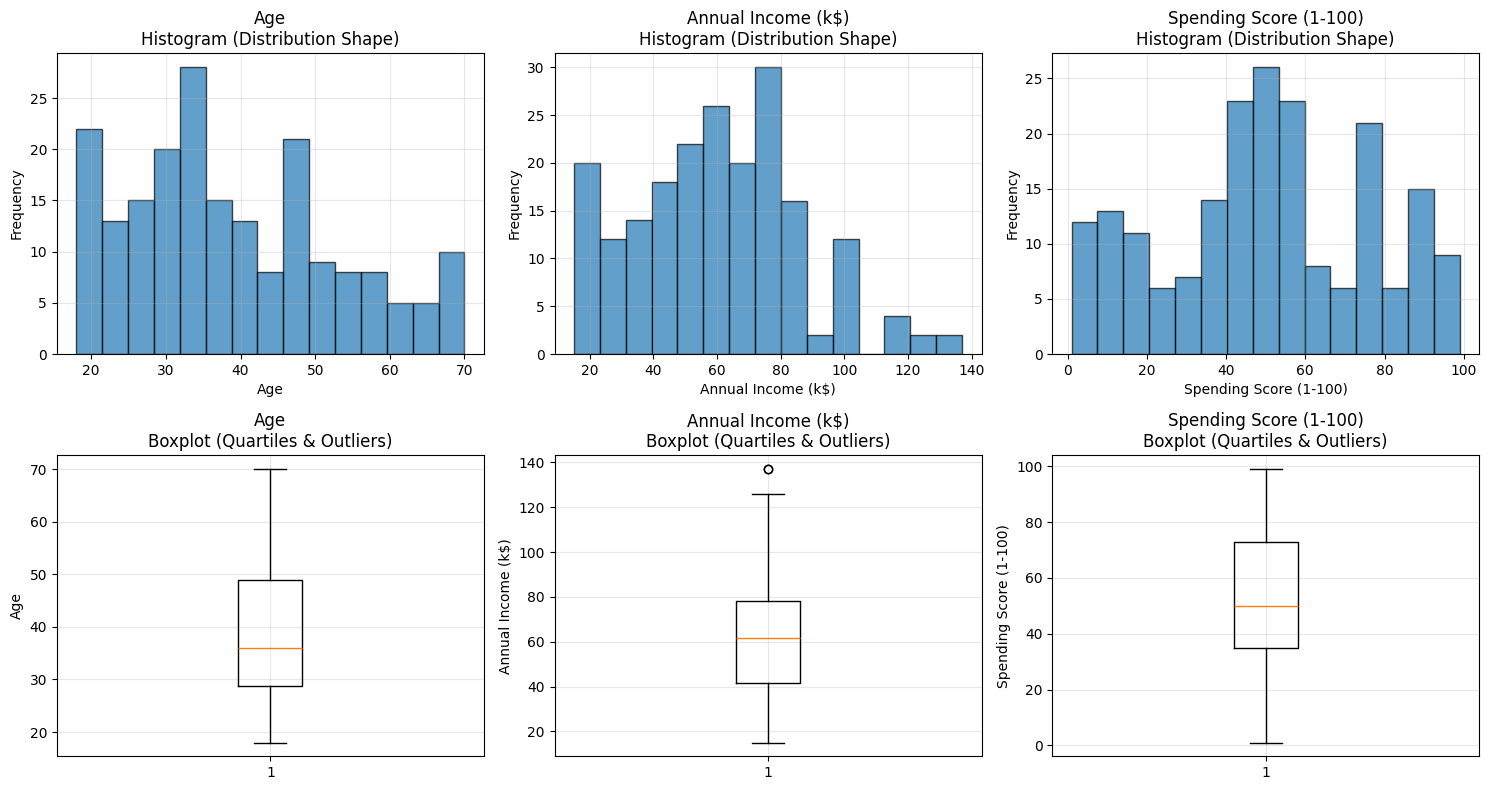

🎯 Outlier Analysis using IQR Method:
(Outliers = values beyond Q1 - 1.5×IQR or Q3 + 1.5×IQR)
Age                      :   0 outliers ( 0.0%)
Annual Income (k$)       :   2 outliers ( 1.0%)
                            Range: 137.0 to 137.0
                            Bounds: [-13.2, 132.8]
Spending Score (1-100)   :   0 outliers ( 0.0%)


In [5]:
# Create histograms and boxplots to visualize distributions and identify outliers
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for i, col in enumerate(numeric_cols):
    # Top row: Histograms show distribution shapes
    axes[0, i].hist(df_clean[col], bins=15, alpha=0.7, edgecolor='black')
    axes[0, i].set_title(f'{col}\nHistogram (Distribution Shape)')
    axes[0, i].set_xlabel(col)
    axes[0, i].set_ylabel('Frequency')
    axes[0, i].grid(True, alpha=0.3)           # Add light grid for readability
    
    # Bottom row: Boxplots show quartiles and outliers
    axes[1, i].boxplot(df_clean[col])
    axes[1, i].set_title(f'{col}\nBoxplot (Quartiles & Outliers)')
    axes[1, i].set_ylabel(col)
    axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()                             # Adjust spacing between plots
plt.show()

# Quantify outliers using the standard IQR method
print("🎯 Outlier Analysis using IQR Method:")
print("=" * 40)
print("(Outliers = values beyond Q1 - 1.5×IQR or Q3 + 1.5×IQR)")

for col in numeric_cols:
    # Calculate quartiles and IQR
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define outlier boundaries
    lower_bound = Q1 - 1.5 * IQR              # Lower outlier threshold
    upper_bound = Q3 + 1.5 * IQR              # Upper outlier threshold
    
    # Find outliers
    outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
    outlier_count = len(outliers)
    outlier_percentage = (outlier_count / len(df_clean)) * 100
    
    print(f"{col:25}: {outlier_count:3d} outliers ({outlier_percentage:4.1f}%)")
    
    # Show outlier range if any exist
    if outlier_count > 0:
        outlier_values = outliers[col]
        print(f"{' ' * 25}   Range: {outlier_values.min():.1f} to {outlier_values.max():.1f}")
        print(f"{' ' * 25}   Bounds: [{lower_bound:.1f}, {upper_bound:.1f}]")

Creating pairwise relationship plots...


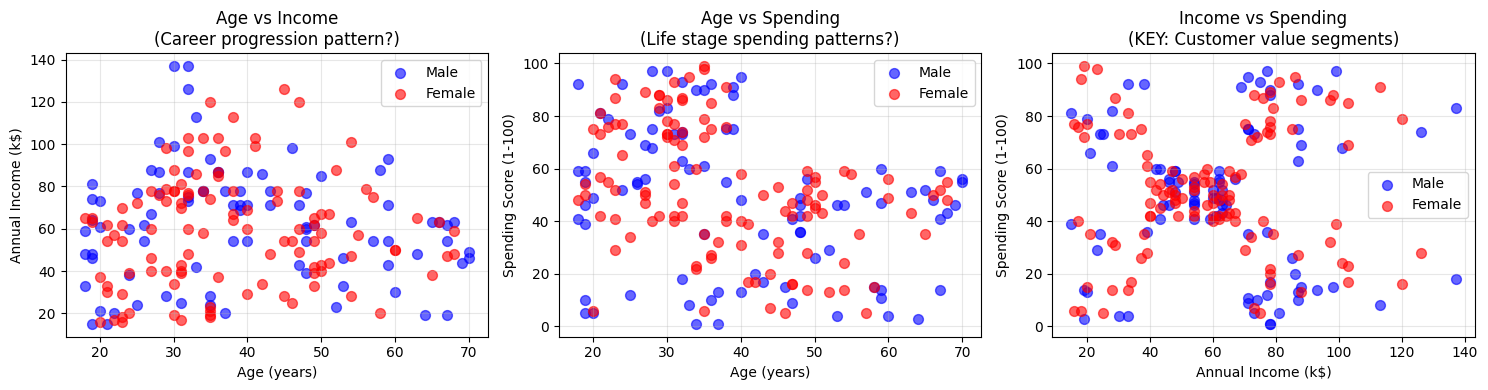

🔍 Visual Pattern Observations:
------------------------------
• Income vs Spending plot is most important for business segmentation
• Look for distinct clusters: High/Low Income × High/Low Spending
• Gender patterns may reveal different shopping behaviors
• Age relationships show life-stage effects on income and spending


In [8]:
# Create pairwise scatter plots colored by Gender to explore relationships
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Define colors for gender groups
colors = {'Male': 'blue', 'Female': 'red'}

# Plot 1: Age vs Annual Income
print("Creating pairwise relationship plots...")
for gender in df_clean['Gender'].unique():
    gender_data = df_clean[df_clean['Gender'] == gender]
    axes[0].scatter(gender_data['Age'], gender_data['Annual Income (k$)'], 
                   c=colors[gender], alpha=0.6, label=gender, s=50)

axes[0].set_xlabel('Age (years)')
axes[0].set_ylabel('Annual Income (k$)')
axes[0].set_title('Age vs Income\n(Career progression pattern?)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Age vs Spending Score  
for gender in df_clean['Gender'].unique():
    gender_data = df_clean[df_clean['Gender'] == gender]
    axes[1].scatter(gender_data['Age'], gender_data['Spending Score (1-100)'], 
                   c=colors[gender], alpha=0.6, label=gender, s=50)

axes[1].set_xlabel('Age (years)')
axes[1].set_ylabel('Spending Score (1-100)')
axes[1].set_title('Age vs Spending\n(Life stage spending patterns?)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Income vs Spending Score (Most important for customer segmentation!)
for gender in df_clean['Gender'].unique():
    gender_data = df_clean[df_clean['Gender'] == gender]
    axes[2].scatter(gender_data['Annual Income (k$)'], gender_data['Spending Score (1-100)'], 
                   c=colors[gender], alpha=0.6, label=gender, s=50)

axes[2].set_xlabel('Annual Income (k$)')
axes[2].set_ylabel('Spending Score (1-100)')
axes[2].set_title('Income vs Spending\n(KEY: Customer value segments)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Provide insights from visual inspection
print("🔍 Visual Pattern Observations:")
print("-" * 30)
print("• Income vs Spending plot is most important for business segmentation")
print("• Look for distinct clusters: High/Low Income × High/Low Spending")
print("• Gender patterns may reveal different shopping behaviors")
print("• Age relationships show life-stage effects on income and spending")

📊 Correlation Matrix (Values between -1 and +1):
                          Age  Annual Income (k$)  Spending Score (1-100)
Age                     1.000              -0.012                  -0.327
Annual Income (k$)     -0.012               1.000                   0.010
Spending Score (1-100) -0.327               0.010                   1.000


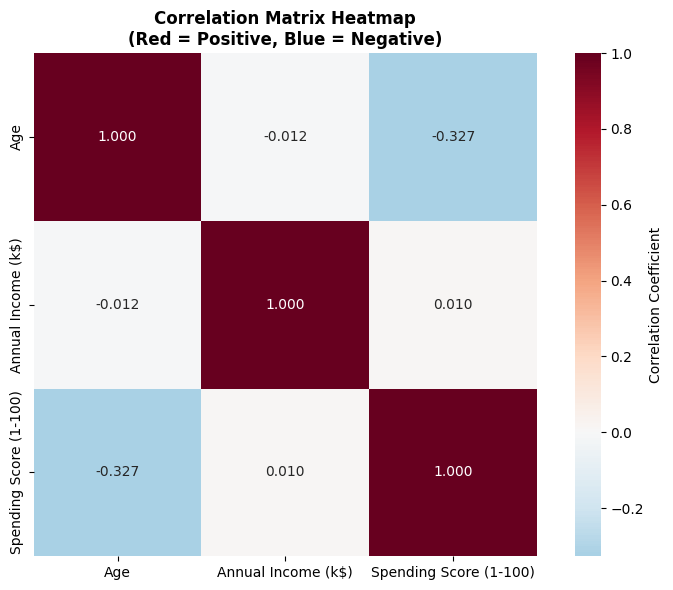


🎯 Correlation Analysis & Business Insights:

Age ↔ Annual Income (k$):
  Correlation: -0.012 (Weak negative)
  💡 Insight: Age doesn't strongly affect annual income (k$)

Age ↔ Spending Score (1-100):
  Correlation: -0.327 (Moderate negative)
  💡 Insight: Age has moderate influence on spending score (1-100)

Annual Income (k$) ↔ Spending Score (1-100):
  Correlation: +0.010 (Weak positive)
  💡 Insight: Income doesn't predict spending - great for segmentation!

🎊 Key Finding:
Income and spending are weakly correlated - perfect for customer segmentation!
This means we can find customers with:
• High income + Low spending (potential targets)
• Low income + High spending (impulse buyers)
• High income + High spending (premium customers)
• Low income + Low spending (budget conscious)


In [9]:
# Calculate correlation matrix to quantify relationships between numeric features
corr_matrix = df_clean[numeric_cols].corr()      # Pearson correlation coefficients
print("📊 Correlation Matrix (Values between -1 and +1):")
print("=" * 45)
print(corr_matrix.round(3))

# Create correlation heatmap for visual representation
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, 
           annot=True,                           # Show correlation values
           cmap='RdBu_r',                       # Red-Blue color scheme (red=positive, blue=negative)
           center=0,                            # Center colormap at zero
           square=True,                         # Make cells square-shaped
           fmt='.3f',                           # 3 decimal places
           cbar_kws={'label': 'Correlation Coefficient'})

plt.title('Correlation Matrix Heatmap\n(Red = Positive, Blue = Negative)', fontweight='bold')
plt.tight_layout()
plt.show()

# Analyze and interpret correlation strengths
print("\n🎯 Correlation Analysis & Business Insights:")
print("=" * 45)

# Examine each pair of variables
for i, col1 in enumerate(numeric_cols):
    for j, col2 in enumerate(numeric_cols):
        if i < j:  # Only examine each pair once
            corr_val = corr_matrix.loc[col1, col2]
            
            # Classify correlation strength
            if abs(corr_val) >= 0.7:
                strength = "Strong"
            elif abs(corr_val) >= 0.3:
                strength = "Moderate"
            else:
                strength = "Weak"
            
            # Determine direction
            direction = "positive" if corr_val > 0 else "negative"
            
            print(f"\n{col1} ↔ {col2}:")
            print(f"  Correlation: {corr_val:+.3f} ({strength} {direction})")
            
            # Provide business interpretation
            if 'Income' in col1 and 'Spending' in col2:
                if abs(corr_val) < 0.3:
                    print(f"  💡 Insight: Income doesn't predict spending - great for segmentation!")
                else:
                    print(f"  💡 Insight: {'Higher' if corr_val > 0 else 'Lower'} income → {'higher' if corr_val > 0 else 'lower'} spending")
            elif 'Age' in col1:
                if abs(corr_val) > 0.3:
                    print(f"  💡 Insight: Age has {strength.lower()} influence on {col2.lower()}")
                else:
                    print(f"  💡 Insight: Age doesn't strongly affect {col2.lower()}")

# Summary insight
print(f"\n🎊 Key Finding:")
income_spending_corr = corr_matrix.loc['Annual Income (k$)', 'Spending Score (1-100)']
if abs(income_spending_corr) < 0.3:
    print("Income and spending are weakly correlated - perfect for customer segmentation!")
    print("This means we can find customers with:")
    print("• High income + Low spending (potential targets)")
    print("• Low income + High spending (impulse buyers)")
    print("• High income + High spending (premium customers)")
    print("• Low income + Low spending (budget conscious)")
else:
    print(f"Income and spending show {abs(income_spending_corr):.2f} correlation")
    print("Clustering may still reveal interesting customer segments")

## Part C: Feature Engineering (15 points)

Now we'll create new features that might help our clustering algorithms identify more meaningful customer segments. Good feature engineering can reveal hidden patterns and improve clustering quality by capturing business-relevant relationships in the data.

In [10]:
# Create a working copy of our cleaned dataset for feature engineering
df_features = df_clean.copy()

print("🔧 Creating Derived Features for Better Clustering")
print("=" * 50)

# Feature 1: Income to Spending Ratio
# This ratio helps identify conservative vs. generous spenders relative to their income
df_features['Income_to_Spend'] = df_features['Annual Income (k$)'] / (df_features['Spending Score (1-100)'] + 1)
# Note: +1 prevents division by zero if spending score is 0

print("✅ Feature 1: Income_to_Spend Ratio")
print("   Purpose: Identifies conservative spenders vs. big spenders relative to income")
print("   Formula: Annual Income / (Spending Score + 1)")
print(f"   Range: {df_features['Income_to_Spend'].min():.2f} to {df_features['Income_to_Spend'].max():.2f}")
print(f"   Mean: {df_features['Income_to_Spend'].mean():.2f}")
print("   High values = Conservative spenders, Low values = Generous spenders")

# Feature 2: Age Groups (Life Stage Segmentation)
# Convert continuous age into meaningful life stage categories
def categorize_age(age):
    """Convert age into life stage categories for clustering"""
    if age < 25:
        return 0      # Young (starting careers, lower income, experimental spending)
    elif age < 35:
        return 1      # Young Adult (career building, increasing income, lifestyle spending)
    elif age < 50:
        return 2      # Middle Age (peak earning, family responsibilities, strategic spending)
    else:
        return 3      # Senior (established income, experience-based spending, potentially fixed income)

df_features['AgeGroup'] = df_features['Age'].apply(categorize_age)

print(f"\n✅ Feature 2: AgeGroup (Life Stage Categories)")
print("   Purpose: Captures life-stage differences in spending patterns")
print("   Categories: 0=Young(<25), 1=Young Adult(25-34), 2=Middle Age(35-49), 3=Senior(50+)")

# Show age group distribution
age_group_counts = df_features['AgeGroup'].value_counts().sort_index()
age_labels = {0: 'Young (<25)', 1: 'Young Adult (25-34)', 2: 'Middle Age (35-49)', 3: 'Senior (50+)'}

for group, count in age_group_counts.items():
    percentage = (count / len(df_features)) * 100
    print(f"   {age_labels[group]}: {count} customers ({percentage:.1f}%)")

# Feature 3: Test log transformation for skewed income distribution
print(f"\n🔍 Testing Log Transformation for Income Skewness:")
income_skew = df_features['Annual Income (k$)'].skew()
print(f"   Original Income Skewness: {income_skew:.3f}")

# Apply log transformation if income is significantly skewed
if abs(income_skew) > 0.5:  # Common threshold for "significant" skewness
    df_features['Log_Income'] = np.log1p(df_features['Annual Income (k$)'])  # log1p handles zero values
    log_income_skew = df_features['Log_Income'].skew()
    print(f"   Log-transformed Income Skewness: {log_income_skew:.3f}")
    
    # Keep log transformation only if it improves normality
    use_log_income = abs(log_income_skew) < abs(income_skew)
    
    if use_log_income:
        print("   ✅ Log transformation improves normality - will use Log_Income")
    else:
        print("   ❌ Log transformation doesn't help - will use original Income")
        df_features.drop('Log_Income', axis=1, inplace=True)  # Remove if not helpful
else:
    use_log_income = False
    print("   ✅ Income distribution is acceptable - no transformation needed")

print(f"   Purpose: Normalize skewed distributions for better clustering performance")

🔧 Creating Derived Features for Better Clustering
✅ Feature 1: Income_to_Spend Ratio
   Purpose: Identifies conservative spenders vs. big spenders relative to income
   Formula: Annual Income / (Spending Score + 1)
   Range: 0.18 to 39.00
   Mean: 2.29
   High values = Conservative spenders, Low values = Generous spenders

✅ Feature 2: AgeGroup (Life Stage Categories)
   Purpose: Captures life-stage differences in spending patterns
   Categories: 0=Young(<25), 1=Young Adult(25-34), 2=Middle Age(35-49), 3=Senior(50+)
   Young (<25): 35 customers (17.5%)
   Young Adult (25-34): 54 customers (27.0%)
   Middle Age (35-49): 66 customers (33.0%)
   Senior (50+): 45 customers (22.5%)

🔍 Testing Log Transformation for Income Skewness:
   Original Income Skewness: 0.322
   ✅ Income distribution is acceptable - no transformation needed
   Purpose: Normalize skewed distributions for better clustering performance


In [11]:
# Prepare the final feature set for clustering algorithms
print("🎯 Preparing Final Feature Set for Clustering")
print("=" * 45)

# Define base features for clustering
features_list = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Income_to_Spend', 'AgeGroup']

# Add log income if it was beneficial
if 'Log_Income' in df_features.columns:
    features_list.append('Log_Income')
    print("📈 Including Log_Income (improved skewness)")

print(f"📋 Selected Features: {features_list}")

# Handle Gender: Encode as binary feature for clustering
# Decision: Include Gender because shopping patterns may differ by gender
le = LabelEncoder()
df_features['Gender_Encoded'] = le.fit_transform(df_features['Gender'])
features_list.append('Gender_Encoded')

# Show encoding mapping
gender_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(f"🚺🚹 Gender Encoding: {gender_mapping}")
print("   Rationale: Gender may influence shopping patterns, binary encoding works with K-means")

# Extract feature matrix for clustering
X = df_features[features_list]

# Apply StandardScaler - CRITICAL for K-means clustering!
print(f"\n⚖️ Applying StandardScaler to Features:")
print("   Why scaling is essential:")
print("   • K-means is sensitive to feature scales (distance-based algorithm)")
print("   • Income (15-137k) has much larger scale than Spending Score (1-100)")
print("   • Without scaling, Income would dominate distance calculations")
print("   • StandardScaler: transforms all features to mean=0, std=1")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)                 # Fit scaler and transform data

# Verify scaling worked correctly
print(f"\n📊 Scaling Verification:")
print("   Original feature ranges:")
for col in features_list:
    print(f"     {col:20}: [{X[col].min():7.2f}, {X[col].max():7.2f}]")

print("   Scaled feature ranges (should be roughly [-3, +3]):")
X_scaled_df = pd.DataFrame(X_scaled, columns=features_list)
for i, col in enumerate(features_list):
    print(f"     {col:20}: [{X_scaled_df[col].min():7.2f}, {X_scaled_df[col].max():7.2f}]")

print(f"\n✅ Feature Engineering Complete!")
print(f"   Final feature matrix shape: {X_scaled.shape}")
print(f"   Features: {len(features_list)} dimensions")
print(f"   Samples: {X_scaled.shape[0]} customers")
print(f"   Ready for clustering algorithms!")

🎯 Preparing Final Feature Set for Clustering
📋 Selected Features: ['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Income_to_Spend', 'AgeGroup']
🚺🚹 Gender Encoding: {'Female': np.int64(0), 'Male': np.int64(1)}
   Rationale: Gender may influence shopping patterns, binary encoding works with K-means

⚖️ Applying StandardScaler to Features:
   Why scaling is essential:
   • K-means is sensitive to feature scales (distance-based algorithm)
   • Income (15-137k) has much larger scale than Spending Score (1-100)
   • Without scaling, Income would dominate distance calculations
   • StandardScaler: transforms all features to mean=0, std=1

📊 Scaling Verification:
   Original feature ranges:
     Age                 : [  18.00,   70.00]
     Annual Income (k$)  : [  15.00,  137.00]
     Spending Score (1-100): [   1.00,   99.00]
     Income_to_Spend     : [   0.18,   39.00]
     AgeGroup            : [   0.00,    3.00]
     Gender_Encoded      : [   0.00,    1.00]
   Scaled feature ran

## Part D: Clustering Modeling (25 points)

Now for the main event - applying K-means and Hierarchical clustering algorithms! We'll systematically evaluate different numbers of clusters using multiple metrics to find the optimal solution. This is where we discover the hidden customer segments in our data.

In [12]:
# K-means Clustering: Systematic evaluation for k=2 to 8 clusters
print("🎯 K-MEANS CLUSTERING EVALUATION")
print("=" * 40)
print("Testing k=2 to 8 clusters with multiple evaluation metrics...")

k_range = range(2, 9)                             # Test 2, 3, 4, 5, 6, 7, 8 clusters
results = []

# For each potential number of clusters
for k in k_range:
    print(f"   Computing k={k}...", end=" ")
    
    # Run K-means with consistent parameters
    kmeans = KMeans(
        n_clusters=k,                              # Number of clusters to find
        random_state=42,                           # Reproducible results
        n_init=10,                                 # Run algorithm 10 times with different initializations
        max_iter=300                               # Maximum iterations for convergence
    )
    
    # Fit model and get cluster assignments
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Calculate all required evaluation metrics
    inertia = kmeans.inertia_                      # Within-cluster sum of squares (WCSS)
    silhouette = silhouette_score(X_scaled, cluster_labels)        # Avg silhouette coefficient
    davies_bouldin = davies_bouldin_score(X_scaled, cluster_labels) # Davies-Bouldin index
    calinski_harabasz = calinski_harabasz_score(X_scaled, cluster_labels) # Calinski-Harabasz index
    
    # Store results for analysis
    results.append({
        'k': k,
        'inertia': inertia,                        # Lower is better (but decreases with k)
        'silhouette': silhouette,                  # Higher is better (range: -1 to 1)
        'davies_bouldin': davies_bouldin,          # Lower is better 
        'calinski_harabasz': calinski_harabasz     # Higher is better
    })
    
    print(f"Silhouette: {silhouette:.3f}")

# Convert results to DataFrame for easy analysis
results_df = pd.DataFrame(results)

print(f"\n K-means Evaluation Results:")
print("=" * 30)
print("Metrics explanation:")
print("• Inertia (WCSS): Lower = tighter clusters, but always decreases with more k")
print("• Silhouette: Higher = better separated clusters (-1 to +1 range)")  
print("• Davies-Bouldin: Lower = better defined clusters")
print("• Calinski-Harabasz: Higher = better defined clusters")
print()
print(results_df.round(3))

# Find optimal k according to each metric
best_silhouette_k = results_df.loc[results_df['silhouette'].idxmax(), 'k']
best_db_k = results_df.loc[results_df['davies_bouldin'].idxmin(), 'k']
best_ch_k = results_df.loc[results_df['calinski_harabasz'].idxmax(), 'k']

print(f"\n Optimal k according to each metric:")
print(f"   Best Silhouette Score: k = {best_silhouette_k} (score: {results_df.loc[results_df['k']==best_silhouette_k, 'silhouette'].iloc[0]:.4f})")
print(f"   Best Davies-Bouldin: k = {best_db_k} (score: {results_df.loc[results_df['k']==best_db_k, 'davies_bouldin'].iloc[0]:.4f})")
print(f"   Best Calinski-Harabasz: k = {best_ch_k} (score: {results_df.loc[results_df['k']==best_ch_k, 'calinski_harabasz'].iloc[0]:.1f})")

# Choose optimal k (prioritize Silhouette as it's most interpretable)
optimal_k = int(best_silhouette_k)
print(f"\n Chosen optimal k: {optimal_k} (based on Silhouette Score)")
print(f"   Rationale: Silhouette score balances cluster cohesion and separation")

🎯 K-MEANS CLUSTERING EVALUATION
Testing k=2 to 8 clusters with multiple evaluation metrics...
   Computing k=2... Silhouette: 0.285
   Computing k=3... Silhouette: 0.292
   Computing k=4... Silhouette: 0.294
   Computing k=5... Silhouette: 0.285
   Computing k=3... Silhouette: 0.292
   Computing k=4... Silhouette: 0.294
   Computing k=5... Silhouette: 0.289
   Computing k=6... Silhouette: 0.306
   Computing k=7... Silhouette: 0.289
   Computing k=6... Silhouette: 0.306
   Computing k=7... Silhouette: 0.321
   Computing k=8... Silhouette: 0.342

 K-means Evaluation Results:
Metrics explanation:
• Inertia (WCSS): Lower = tighter clusters, but always decreases with more k
• Silhouette: Higher = better separated clusters (-1 to +1 range)
• Davies-Bouldin: Lower = better defined clusters
• Calinski-Harabasz: Higher = better defined clusters

   k  inertia  silhouette  davies_bouldin  calinski_harabasz
0  2  859.911       0.285           1.452             78.308
1  3  708.342       0.292    

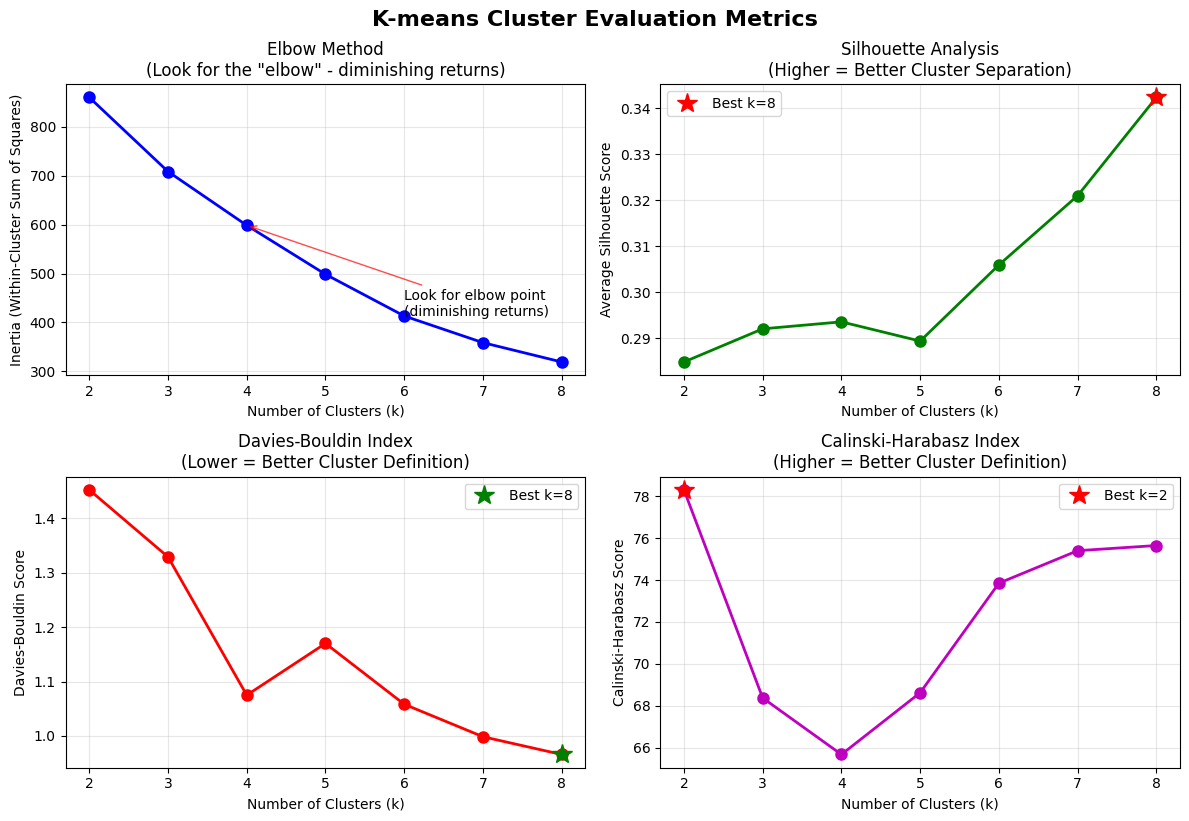

📈 Visual Analysis Guide:
• Elbow Method: Look for the 'elbow' where improvement slows down
• Silhouette: Higher values indicate well-separated, cohesive clusters
• Davies-Bouldin: Lower values mean clusters are compact and well-separated
• Calinski-Harabasz: Higher values indicate dense, well-separated clusters


In [13]:
# Visualize all metrics to understand the optimal k selection
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot 1: Elbow Method (Inertia/WCSS)
axes[0,0].plot(results_df['k'], results_df['inertia'], 'bo-', linewidth=2, markersize=8)
axes[0,0].set_title('Elbow Method\n(Look for the "elbow" - diminishing returns)')
axes[0,0].set_xlabel('Number of Clusters (k)')
axes[0,0].set_ylabel('Inertia (Within-Cluster Sum of Squares)')
axes[0,0].grid(True, alpha=0.3)

# Highlight the elbow visually
axes[0,0].annotate('Look for elbow point\n(diminishing returns)', 
                   xy=(4, results_df[results_df['k']==4]['inertia'].iloc[0]), 
                   xytext=(6, results_df[results_df['k']==6]['inertia'].iloc[0]),
                   arrowprops=dict(arrowstyle='->', color='red', alpha=0.7))

# Plot 2: Silhouette Score (Higher is Better)
axes[0,1].plot(results_df['k'], results_df['silhouette'], 'go-', linewidth=2, markersize=8)
axes[0,1].set_title('Silhouette Analysis\n(Higher = Better Cluster Separation)')
axes[0,1].set_xlabel('Number of Clusters (k)')
axes[0,1].set_ylabel('Average Silhouette Score')
axes[0,1].grid(True, alpha=0.3)

# Mark the best silhouette score
best_sil_row = results_df.loc[results_df['silhouette'].idxmax()]
axes[0,1].plot(best_sil_row['k'], best_sil_row['silhouette'], 'r*', markersize=15, label=f'Best k={int(best_sil_row["k"])}')
axes[0,1].legend()

# Plot 3: Davies-Bouldin Index (Lower is Better)  
axes[1,0].plot(results_df['k'], results_df['davies_bouldin'], 'ro-', linewidth=2, markersize=8)
axes[1,0].set_title('Davies-Bouldin Index\n(Lower = Better Cluster Definition)')
axes[1,0].set_xlabel('Number of Clusters (k)')
axes[1,0].set_ylabel('Davies-Bouldin Score')
axes[1,0].grid(True, alpha=0.3)

# Mark the best Davies-Bouldin score
best_db_row = results_df.loc[results_df['davies_bouldin'].idxmin()]
axes[1,0].plot(best_db_row['k'], best_db_row['davies_bouldin'], 'g*', markersize=15, label=f'Best k={int(best_db_row["k"])}')
axes[1,0].legend()

# Plot 4: Calinski-Harabasz Index (Higher is Better)
axes[1,1].plot(results_df['k'], results_df['calinski_harabasz'], 'mo-', linewidth=2, markersize=8)
axes[1,1].set_title('Calinski-Harabasz Index\n(Higher = Better Cluster Definition)')
axes[1,1].set_xlabel('Number of Clusters (k)')
axes[1,1].set_ylabel('Calinski-Harabasz Score')
axes[1,1].grid(True, alpha=0.3)

# Mark the best Calinski-Harabasz score
best_ch_row = results_df.loc[results_df['calinski_harabasz'].idxmax()]
axes[1,1].plot(best_ch_row['k'], best_ch_row['calinski_harabasz'], 'r*', markersize=15, label=f'Best k={int(best_ch_row["k"])}')
axes[1,1].legend()

plt.tight_layout()
plt.suptitle('K-means Cluster Evaluation Metrics', fontsize=16, fontweight='bold', y=1.02)
plt.show()

print("📈 Visual Analysis Guide:")
print("• Elbow Method: Look for the 'elbow' where improvement slows down")
print("• Silhouette: Higher values indicate well-separated, cohesive clusters")
print("• Davies-Bouldin: Lower values mean clusters are compact and well-separated")
print("• Calinski-Harabasz: Higher values indicate dense, well-separated clusters")

🌳 HIERARCHICAL CLUSTERING ANALYSIS
Computing pairwise distances between customers...
✅ Distance matrix computed (19900 pairwise distances)

🔗 Ward Linkage Analysis:
   Method: Minimizes within-cluster variance at each merge
   Best for: Compact, spherical clusters (similar to K-means)
   Cophenetic Correlation: 0.5264
   ⚠️ Moderate preservation of original distances

🔗 Complete Linkage Analysis:
   Method: Uses maximum distance between any two points in different clusters
   Best for: Compact clusters, sensitive to outliers
   Cophenetic Correlation: 0.6787
   ✅ Good preservation of original distances

⚖️ Method Comparison:
   Ward Cophenetic Correlation:     0.5264
   Complete Cophenetic Correlation: 0.6787
   🏆 Complete linkage better preserves original distances
   Difference: 0.1523
   Selected method: COMPLETE


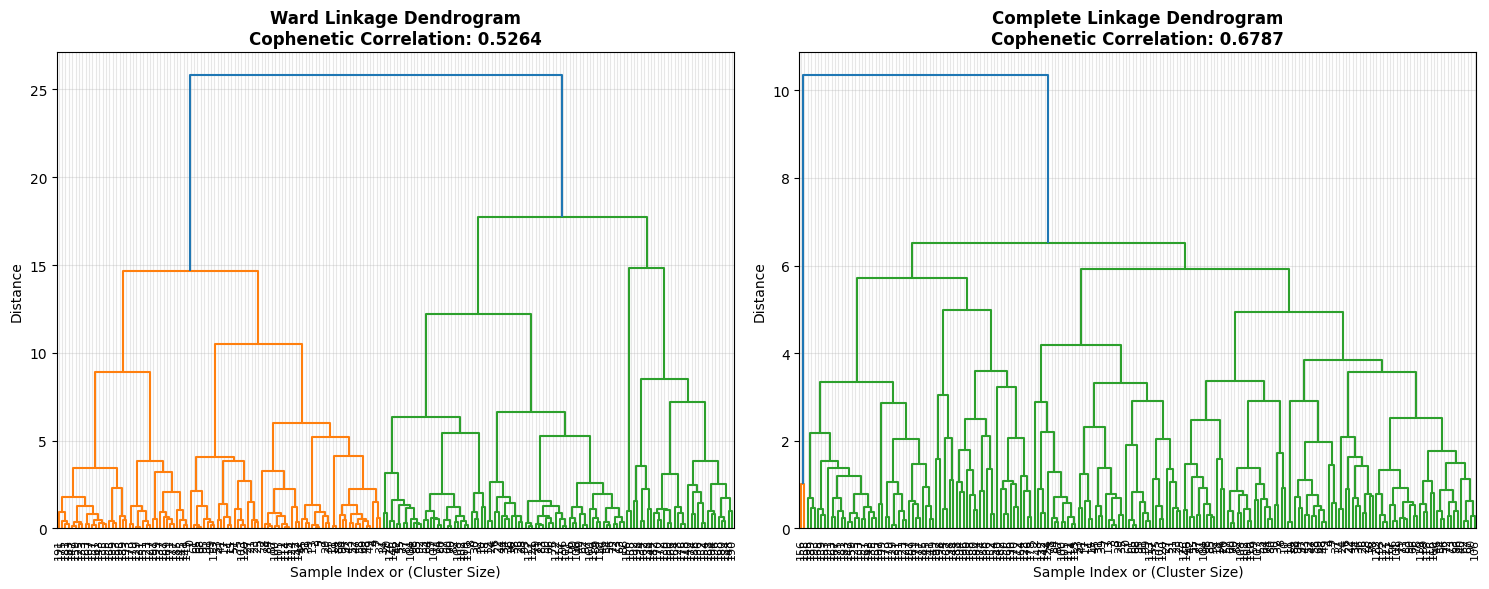


📊 Dendrogram Interpretation:
• Height of merges indicates distance between clusters being joined
• Horizontal cuts at different heights give different numbers of clusters
• Look for large gaps in height - good places to cut the tree
• Complete method selected for further analysis


In [14]:
# Hierarchical Clustering: Compare Ward vs Complete Linkage
print("🌳 HIERARCHICAL CLUSTERING ANALYSIS")
print("=" * 40)

# Step 1: Compute pairwise distances between all data points
print("Computing pairwise distances between customers...")
distance_matrix = pdist(X_scaled, metric='euclidean')    # Euclidean distance in scaled space
print(f"✅ Distance matrix computed ({len(distance_matrix)} pairwise distances)")

# Step 2: Ward Linkage - minimizes within-cluster variance
print(f"\n🔗 Ward Linkage Analysis:")
print("   Method: Minimizes within-cluster variance at each merge")
print("   Best for: Compact, spherical clusters (similar to K-means)")

linkage_ward = linkage(distance_matrix, method='ward')   # Build hierarchy using Ward criterion
cophenet_ward, _ = cophenet(linkage_ward, distance_matrix)  # Measure how well hierarchy preserves distances

print(f"   Cophenetic Correlation: {cophenet_ward:.4f}")
if cophenet_ward > 0.7:
    print("   🎯 Excellent preservation of original distances")
elif cophenet_ward > 0.6:
    print("   ✅ Good preservation of original distances")
else:
    print("   ⚠️ Moderate preservation of original distances")

# Step 3: Complete Linkage - uses maximum distance between clusters
print(f"\n🔗 Complete Linkage Analysis:")
print("   Method: Uses maximum distance between any two points in different clusters")
print("   Best for: Compact clusters, sensitive to outliers")

linkage_complete = linkage(distance_matrix, method='complete')  # Build hierarchy using Complete criterion
cophenet_complete, _ = cophenet(linkage_complete, distance_matrix)

print(f"   Cophenetic Correlation: {cophenet_complete:.4f}")
if cophenet_complete > 0.7:
    print("   🎯 Excellent preservation of original distances")
elif cophenet_complete > 0.6:
    print("   ✅ Good preservation of original distances")
else:
    print("   ⚠️ Moderate preservation of original distances")

# Step 4: Compare methods and choose better one
print(f"\n⚖️ Method Comparison:")
print(f"   Ward Cophenetic Correlation:     {cophenet_ward:.4f}")
print(f"   Complete Cophenetic Correlation: {cophenet_complete:.4f}")

if cophenet_ward > cophenet_complete:
    better_linkage = 'ward'
    better_correlation = cophenet_ward
    print(f"   🏆 Ward linkage better preserves original distances")
else:
    better_linkage = 'complete' 
    better_correlation = cophenet_complete
    print(f"   🏆 Complete linkage better preserves original distances")

print(f"   Difference: {abs(cophenet_ward - cophenet_complete):.4f}")
print(f"   Selected method: {better_linkage.upper()}")

# Step 5: Create dendrograms to visualize hierarchical structure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Ward dendrogram
dendrogram(linkage_ward, ax=ax1, leaf_font_size=8, orientation='top')
ax1.set_title(f'Ward Linkage Dendrogram\nCophenetic Correlation: {cophenet_ward:.4f}', fontweight='bold')
ax1.set_xlabel('Sample Index or (Cluster Size)')
ax1.set_ylabel('Distance')
ax1.grid(True, alpha=0.3)

# Complete dendrogram
dendrogram(linkage_complete, ax=ax2, leaf_font_size=8, orientation='top')
ax2.set_title(f'Complete Linkage Dendrogram\nCophenetic Correlation: {cophenet_complete:.4f}', fontweight='bold')
ax2.set_xlabel('Sample Index or (Cluster Size)')
ax2.set_ylabel('Distance')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Dendrogram Interpretation:")
print("• Height of merges indicates distance between clusters being joined")
print("• Horizontal cuts at different heights give different numbers of clusters")
print("• Look for large gaps in height - good places to cut the tree")
print(f"• {better_linkage.capitalize()} method selected for further analysis")

In [15]:
# Evaluate hierarchical clustering for different numbers of clusters (2-6)
print(f"📊 HIERARCHICAL CLUSTERING EVALUATION ({better_linkage.upper()})")
print("=" * 55)
print("Testing 2-6 clusters to find optimal cut point...")

cluster_range = range(2, 7)                           # Test 2, 3, 4, 5, 6 clusters
hier_results = []

# For each potential number of clusters
for n_clusters in cluster_range:
    print(f"   Evaluating {n_clusters} clusters...", end=" ")
    
    # Create agglomerative clustering model with chosen linkage
    agg_clustering = AgglomerativeClustering(
        n_clusters=n_clusters,                         # Number of clusters to create
        linkage=better_linkage,                        # Use the better-performing linkage method
        metric='euclidean'                             # Distance metric
    )
    
    # Fit model and get cluster assignments
    cluster_labels = agg_clustering.fit_predict(X_scaled)
    
    # Evaluate clustering quality
    sil_score = silhouette_score(X_scaled, cluster_labels)           # Higher = better
    db_score = davies_bouldin_score(X_scaled, cluster_labels)        # Lower = better
    
    # Store results
    hier_results.append({
        'n_clusters': n_clusters,
        'silhouette': sil_score,
        'davies_bouldin': db_score
    })
    
    print(f"Silhouette: {sil_score:.4f}")

# Convert to DataFrame for analysis
hier_df = pd.DataFrame(hier_results)

print(f"\n📋 Hierarchical Clustering Results ({better_linkage}):")
print(hier_df.round(4))

# Find best hierarchical solutions
best_hier_sil_idx = hier_df['silhouette'].idxmax()
best_hier_db_idx = hier_df['davies_bouldin'].idxmin()

best_hier_sil_clusters = int(hier_df.loc[best_hier_sil_idx, 'n_clusters'])
best_hier_db_clusters = int(hier_df.loc[best_hier_db_idx, 'n_clusters'])

print(f"\n🏆 Best Hierarchical Results:")
print(f"   Best Silhouette: {best_hier_sil_clusters} clusters (score: {hier_df.loc[best_hier_sil_idx, 'silhouette']:.4f})")
print(f"   Best Davies-Bouldin: {best_hier_db_clusters} clusters (score: {hier_df.loc[best_hier_db_idx, 'davies_bouldin']:.4f})")

# Choose final hierarchical solution (prioritize Silhouette)
best_hier_clusters = best_hier_sil_clusters
print(f"   Selected: {best_hier_clusters} clusters")

# Compare K-means vs Hierarchical clustering
print(f"\n⚖️ K-MEANS vs HIERARCHICAL COMPARISON:")
print("=" * 45)

# Get K-means performance for chosen k
kmeans_silhouette = results_df[results_df['k'] == optimal_k]['silhouette'].iloc[0]
kmeans_db = results_df[results_df['k'] == optimal_k]['davies_bouldin'].iloc[0]

# Get Hierarchical performance for chosen clusters
hier_silhouette = hier_df[hier_df['n_clusters'] == best_hier_clusters]['silhouette'].iloc[0]
hier_db = hier_df[hier_df['n_clusters'] == best_hier_clusters]['davies_bouldin'].iloc[0]

print(f"K-means (k={optimal_k}):")
print(f"   Silhouette Score: {kmeans_silhouette:.4f}")
print(f"   Davies-Bouldin: {kmeans_db:.4f}")

print(f"\nHierarchical {better_linkage} ({best_hier_clusters} clusters):")
print(f"   Silhouette Score: {hier_silhouette:.4f}")
print(f"   Davies-Bouldin: {hier_db:.4f}")
print(f"   Cophenetic Correlation: {better_correlation:.4f}")

# Determine overall winner
print(f"\n🏆 OVERALL PERFORMANCE:")
if kmeans_silhouette > hier_silhouette:
    print(f"   K-means shows superior clustering quality")
    print(f"   Silhouette advantage: +{kmeans_silhouette - hier_silhouette:.4f}")
    winner = "K-means"
else:
    print(f"   Hierarchical clustering shows superior quality")
    print(f"   Silhouette advantage: +{hier_silhouette - kmeans_silhouette:.4f}")
    winner = "Hierarchical"

print(f"\n💡 Method Insights:")
print(f"   • K-means: Fast, assumes spherical clusters, needs k specified")
print(f"   • Hierarchical: Shows cluster relationships, deterministic, computationally intensive")
print(f"   • Both methods reveal customer segments - choose based on business needs")

📊 HIERARCHICAL CLUSTERING EVALUATION (COMPLETE)
Testing 2-6 clusters to find optimal cut point...
   Evaluating 2 clusters... Silhouette: 0.6629
   Evaluating 3 clusters... Silhouette: 0.1608
   Evaluating 4 clusters... Silhouette: 0.2058
   Evaluating 5 clusters... Silhouette: 0.2558
   Evaluating 6 clusters... Silhouette: 0.2474

📋 Hierarchical Clustering Results (complete):
   n_clusters  silhouette  davies_bouldin
0           2      0.6629          0.3058
1           3      0.1608          1.6929
2           4      0.2058          1.3743
3           5      0.2558          1.1447
4           6      0.2474          1.1240

🏆 Best Hierarchical Results:
   Best Silhouette: 2 clusters (score: 0.6629)
   Best Davies-Bouldin: 2 clusters (score: 0.3058)
   Selected: 2 clusters

⚖️ K-MEANS vs HIERARCHICAL COMPARISON:
K-means (k=8):
   Silhouette Score: 0.3424
   Davies-Bouldin: 0.9658

Hierarchical complete (2 clusters):
   Silhouette Score: 0.6629
   Davies-Bouldin: 0.3058
   Cophenetic Co

## Part E: Statistical Testing (15 points)

Time to validate our clustering results! We'll use statistical tests to confirm that our identified clusters represent truly different customer groups. This step proves that our clusters aren't just random groupings but reflect meaningful differences in customer characteristics.

In [16]:
# Generate final cluster assignments for our chosen optimal solutions
print("🎯 GENERATING FINAL CLUSTER ASSIGNMENTS")
print("=" * 45)

# Create final K-means model with optimal k
print(f"1. K-means Clustering (k={optimal_k}):")
kmeans_final = KMeans(
    n_clusters=optimal_k, 
    random_state=42,                               # Ensure reproducible results
    n_init=10                                      # Multiple random starts for stability
)
kmeans_labels = kmeans_final.fit_predict(X_scaled)     # Final cluster assignments
df_features['KMeans_Cluster'] = kmeans_labels          # Add to dataframe

print(f"   ✅ {len(set(kmeans_labels))} clusters assigned")
print(f"   Cluster distribution: {sorted(pd.Series(kmeans_labels).value_counts().values)}")

# Create final Hierarchical model with optimal clusters
print(f"\n2. Hierarchical Clustering ({better_linkage}, {best_hier_clusters} clusters):")
hier_final = AgglomerativeClustering(
    n_clusters=best_hier_clusters, 
    linkage=better_linkage                         # Use the better-performing linkage
)
hier_labels = hier_final.fit_predict(X_scaled)         # Final cluster assignments  
df_features['Hier_Cluster'] = hier_labels              # Add to dataframe

print(f"   ✅ {len(set(hier_labels))} clusters assigned")
print(f"   Cluster distribution: {sorted(pd.Series(hier_labels).value_counts().values)}")

# Compute cluster centroids in original (unscaled) units for business interpretation
print(f"\n📊 CLUSTER CENTROIDS (Original Units)")
print("=" * 40)
print("Centroids show the 'average customer' in each cluster")

# K-means centroids
print(f"\n🎯 K-MEANS CENTROIDS (k={optimal_k}):")
print("-" * 30)
kmeans_centroids = df_features.groupby('KMeans_Cluster')[features_list].mean()
print(kmeans_centroids.round(2))

# Add business-friendly interpretation
print(f"\nCluster Sizes & Percentages:")
kmeans_cluster_counts = pd.Series(kmeans_labels).value_counts().sort_index()
for cluster_id, count in kmeans_cluster_counts.items():
    percentage = (count / len(df_features)) * 100
    print(f"   Cluster {cluster_id}: {count:3d} customers ({percentage:4.1f}%)")

# Hierarchical centroids
print(f"\n🌳 HIERARCHICAL CENTROIDS ({better_linkage}, {best_hier_clusters} clusters):")
print("-" * 50)
hier_centroids = df_features.groupby('Hier_Cluster')[features_list].mean()
print(hier_centroids.round(2))

print(f"\nCluster Sizes & Percentages:")
hier_cluster_counts = pd.Series(hier_labels).value_counts().sort_index()
for cluster_id, count in hier_cluster_counts.items():
    percentage = (count / len(df_features)) * 100
    print(f"   Cluster {cluster_id}: {count:3d} customers ({percentage:4.1f}%)")

print(f"\n💡 Centroid Interpretation Guide:")
print("• Age: Average age of customers in cluster")
print("• Annual Income: Average income level (k$ = thousands)")
print("• Spending Score: Average spending behavior (1-100 scale)")
print("• Income_to_Spend: Ratio indicating spending conservatism")
print("• AgeGroup: Dominant life stage (0=Young, 1=Young Adult, 2=Middle Age, 3=Senior)")
print("• Gender_Encoded: Gender split (0=Female, 1=Male; 0.5=50/50 split)")

🎯 GENERATING FINAL CLUSTER ASSIGNMENTS
1. K-means Clustering (k=8):
   ✅ 8 clusters assigned
   Cluster distribution: [np.int64(2), np.int64(18), np.int64(21), np.int64(21), np.int64(26), np.int64(35), np.int64(36), np.int64(41)]

2. Hierarchical Clustering (complete, 2 clusters):
   ✅ 2 clusters assigned
   Cluster distribution: [np.int64(2), np.int64(198)]

📊 CLUSTER CENTROIDS (Original Units)
Centroids show the 'average customer' in each cluster

🎯 K-MEANS CENTROIDS (k=8):
------------------------------
                  Age  Annual Income (k$)  Spending Score (1-100)  \
KMeans_Cluster                                                      
0               33.28               87.11                   82.67   
1               25.69               42.81                   58.08   
2               39.04               91.08                   16.58   
3               50.07               48.34                   40.88   
4               55.37               52.34                   37.51   
5    

In [17]:
# Statistical tests for numeric features - prove clusters are significantly different
print("📈 STATISTICAL TESTING: NUMERIC FEATURES")
print("=" * 45)
print("Testing if clusters have significantly different means on key features")

# Features to test for significant differences between clusters
test_features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Income_to_Spend']

print("\nTest Logic:")
print("• H0 (Null): All clusters have the same mean for this feature") 
print("• H1 (Alternative): At least one cluster has a different mean")
print("• If p-value < 0.05: Reject H0 → Clusters ARE significantly different")
print("• If p-value ≥ 0.05: Fail to reject H0 → No significant difference")

for feature in test_features:
    print(f"\n{'='*60}")
    print(f"🔍 TESTING: {feature}")
    print('='*60)
    
    # Test K-means clusters
    print(f"\n🎯 K-means Clusters (k={optimal_k}):")
    
    # Group data by K-means cluster assignment
    groups_kmeans = [df_features[df_features['KMeans_Cluster'] == cluster][feature].values 
                     for cluster in range(optimal_k)]
    
    # Choose appropriate test (ANOVA vs Kruskal-Wallis)
    try:
        # Try ANOVA first (assumes normality and equal variances)
        f_statistic, p_value_k = f_oneway(*groups_kmeans)
        test_used_k = "ANOVA (F-test)"
        print(f"   Test: {test_used_k}")
        print(f"   F-statistic: {f_statistic:.4f}")
    except:
        # Fallback to non-parametric Kruskal-Wallis test
        h_statistic, p_value_k = kruskal(*groups_kmeans)
        test_used_k = "Kruskal-Wallis (non-parametric)"
        print(f"   Test: {test_used_k}")
        print(f"   H-statistic: {h_statistic:.4f}")
    
    # Interpret results
    print(f"   P-value: {p_value_k:.6f}")
    if p_value_k < 0.05:
        significance_k = "🎯 SIGNIFICANT"
        print(f"   Result: {significance_k} - Clusters differ significantly on {feature}")
    else:
        significance_k = "❌ NOT SIGNIFICANT" 
        print(f"   Result: {significance_k} - No significant difference between clusters")
    
    # Test Hierarchical clusters
    print(f"\n🌳 Hierarchical Clusters ({better_linkage}, {best_hier_clusters} clusters):")
    
    # Group data by Hierarchical cluster assignment
    groups_hier = [df_features[df_features['Hier_Cluster'] == cluster][feature].values 
                   for cluster in range(best_hier_clusters)]
    
    # Choose appropriate test
    try:
        # Try ANOVA first
        f_statistic, p_value_h = f_oneway(*groups_hier)
        test_used_h = "ANOVA (F-test)"
        print(f"   Test: {test_used_h}")
        print(f"   F-statistic: {f_statistic:.4f}")
    except:
        # Fallback to Kruskal-Wallis
        h_statistic, p_value_h = kruskal(*groups_hier)
        test_used_h = "Kruskal-Wallis (non-parametric)"
        print(f"   Test: {test_used_h}")
        print(f"   H-statistic: {h_statistic:.4f}")
    
    # Interpret results
    print(f"   P-value: {p_value_h:.6f}")
    if p_value_h < 0.05:
        significance_h = "🎯 SIGNIFICANT"
        print(f"   Result: {significance_h} - Clusters differ significantly on {feature}")
    else:
        significance_h = "❌ NOT SIGNIFICANT"
        print(f"   Result: {significance_h} - No significant difference between clusters")
    
    # Summary for this feature
    print(f"\n📊 Summary for {feature}:")
    print(f"   K-means: {significance_k} (p = {p_value_k:.6f})")
    print(f"   Hierarchical: {significance_h} (p = {p_value_h:.6f})")

print(f"\n💡 Statistical Testing Interpretation:")
print("• Significant results validate that clusters represent distinct customer groups")
print("• Non-significant results suggest clusters don't differ much on that feature")  
print("• Strong clustering should show significance on most key business features")

📈 STATISTICAL TESTING: NUMERIC FEATURES
Testing if clusters have significantly different means on key features

Test Logic:
• H0 (Null): All clusters have the same mean for this feature
• H1 (Alternative): At least one cluster has a different mean
• If p-value < 0.05: Reject H0 → Clusters ARE significantly different
• If p-value ≥ 0.05: Fail to reject H0 → No significant difference

🔍 TESTING: Age

🎯 K-means Clusters (k=8):
   Test: ANOVA (F-test)
   F-statistic: 65.9503
   P-value: 0.000000
   Result: 🎯 SIGNIFICANT - Clusters differ significantly on Age

🌳 Hierarchical Clusters (complete, 2 clusters):
   Test: ANOVA (F-test)
   F-statistic: 0.1157
   P-value: 0.734140
   Result: ❌ NOT SIGNIFICANT - No significant difference between clusters

📊 Summary for Age:
   K-means: 🎯 SIGNIFICANT (p = 0.000000)
   Hierarchical: ❌ NOT SIGNIFICANT (p = 0.734140)

🔍 TESTING: Annual Income (k$)

🎯 K-means Clusters (k=8):
   Test: ANOVA (F-test)
   F-statistic: 37.3345
   P-value: 0.000000
   Result:

In [18]:
# Chi-square tests for categorical variables - test independence
print("🔢 STATISTICAL TESTING: CATEGORICAL FEATURES")
print("=" * 50)
print("Testing if categorical features are independent of cluster membership")

# Test categorical variables for association with clusters
categorical_vars = ['Gender']

print("\nTest Logic:")
print("• H0 (Null): Feature is independent of cluster membership (no association)")
print("• H1 (Alternative): Feature and clusters are associated") 
print("• If p-value < 0.05: Reject H0 → Feature IS associated with clusters")
print("• If p-value ≥ 0.05: Fail to reject H0 → No significant association")

for var in categorical_vars:
    print(f"\n{'='*60}")
    print(f"🔍 TESTING: {var}")
    print('='*60)
    
    # Test K-means clusters
    print(f"\n🎯 K-means Clusters × {var}:")
    
    # Create contingency table (cross-tabulation)
    contingency_kmeans = pd.crosstab(df_features[var], df_features['KMeans_Cluster'], margins=False)
    print(f"   Contingency Table:")
    print(contingency_kmeans)
    
    # Perform Chi-square test of independence
    chi2_k, p_value_k, dof_k, expected_k = chi2_contingency(contingency_kmeans)
    
    print(f"\n   Chi-square statistic: {chi2_k:.4f}")
    print(f"   Degrees of freedom: {dof_k}")
    print(f"   P-value: {p_value_k:.6f}")
    
    # Check test assumptions (expected frequencies should be ≥ 5)
    min_expected_k = expected_k.min()
    print(f"   Minimum expected frequency: {min_expected_k:.2f}")
    
    if min_expected_k < 5:
        print(f"   ⚠️ Warning: Some expected frequencies < 5, test may be unreliable")
    else:
        print(f"   ✅ Expected frequencies adequate for Chi-square test")
    
    # Interpret results
    if p_value_k < 0.05:
        significance_k = "🎯 SIGNIFICANT ASSOCIATION"
        print(f"   Result: {significance_k} - {var} is associated with K-means clusters")
    else:
        significance_k = "❌ NO SIGNIFICANT ASSOCIATION"
        print(f"   Result: {significance_k} - {var} is independent of K-means clusters")
    
    # Calculate effect size (Cramér's V)
    n_k = contingency_kmeans.sum().sum()                              # Total sample size
    cramers_v_k = np.sqrt(chi2_k / (n_k * (min(contingency_kmeans.shape) - 1)))
    
    # Interpret effect size
    if cramers_v_k < 0.1:
        effect_size_k = "Small"
    elif cramers_v_k < 0.3:
        effect_size_k = "Medium"  
    else:
        effect_size_k = "Large"
    
    print(f"   Cramér's V (effect size): {cramers_v_k:.4f} ({effect_size_k} effect)")
    
    # Test Hierarchical clusters
    print(f"\n🌳 Hierarchical Clusters × {var}:")
    
    # Create contingency table for hierarchical clusters
    contingency_hier = pd.crosstab(df_features[var], df_features['Hier_Cluster'], margins=False)
    print(f"   Contingency Table:")
    print(contingency_hier)
    
    # Perform Chi-square test
    chi2_h, p_value_h, dof_h, expected_h = chi2_contingency(contingency_hier)
    
    print(f"\n   Chi-square statistic: {chi2_h:.4f}")
    print(f"   Degrees of freedom: {dof_h}")
    print(f"   P-value: {p_value_h:.6f}")
    
    # Check assumptions
    min_expected_h = expected_h.min()
    print(f"   Minimum expected frequency: {min_expected_h:.2f}")
    
    if min_expected_h < 5:
        print(f"   ⚠️ Warning: Some expected frequencies < 5, test may be unreliable")
    else:
        print(f"   ✅ Expected frequencies adequate for Chi-square test")
    
    # Interpret results
    if p_value_h < 0.05:
        significance_h = "🎯 SIGNIFICANT ASSOCIATION"
        print(f"   Result: {significance_h} - {var} is associated with Hierarchical clusters")
    else:
        significance_h = "❌ NO SIGNIFICANT ASSOCIATION"
        print(f"   Result: {significance_h} - {var} is independent of Hierarchical clusters")
    
    # Calculate effect size
    n_h = contingency_hier.sum().sum()
    cramers_v_h = np.sqrt(chi2_h / (n_h * (min(contingency_hier.shape) - 1)))
    
    if cramers_v_h < 0.1:
        effect_size_h = "Small"
    elif cramers_v_h < 0.3:
        effect_size_h = "Medium"
    else:
        effect_size_h = "Large"
    
    print(f"   Cramér's V (effect size): {cramers_v_h:.4f} ({effect_size_h} effect)")
    
    # Summary for this variable
    print(f"\n📊 Summary for {var}:")
    print(f"   K-means: {significance_k} (p = {p_value_k:.6f}, Cramér's V = {cramers_v_k:.4f})")
    print(f"   Hierarchical: {significance_h} (p = {p_value_h:.6f}, Cramér's V = {cramers_v_h:.4f})")

# Test AgeGroup if it was created
if 'AgeGroup' in df_features.columns:
    print(f"\n{'='*60}")
    print(f"🔍 TESTING: AgeGroup (Life Stages)")
    print('='*60)
    
    # Convert numeric AgeGroup back to labels for better interpretation
    age_group_labels = {0: 'Young', 1: 'Young Adult', 2: 'Middle Age', 3: 'Senior'}
    df_features['AgeGroup_Label'] = df_features['AgeGroup'].map(age_group_labels)
    
    # Test both methods for AgeGroup
    for method_name, cluster_col in [('K-means', 'KMeans_Cluster'), ('Hierarchical', 'Hier_Cluster')]:
        print(f"\n{method_name} Clusters × AgeGroup:")
        contingency = pd.crosstab(df_features['AgeGroup_Label'], df_features[cluster_col])
        print(contingency)
        
        chi2, p_val, dof, expected = chi2_contingency(contingency)
        print(f"   Chi-square: {chi2:.4f}, p-value: {p_val:.6f}")
        
        if p_val < 0.05:
            print(f"   🎯 SIGNIFICANT - AgeGroup associated with {method_name} clusters")
        else:
            print(f"   ❌ NOT SIGNIFICANT - AgeGroup independent of {method_name} clusters")

print(f"\n🎓 Statistical Validation Summary:")
print("=" * 35)
print("• Significant tests confirm clusters represent real customer differences")
print("• Non-significant results may indicate over-segmentation")
print("• Strong clustering should show statistical significance on key business features")
print("• Effect sizes (Cramér's V) show practical significance beyond statistical significance")

🔢 STATISTICAL TESTING: CATEGORICAL FEATURES
Testing if categorical features are independent of cluster membership

Test Logic:
• H0 (Null): Feature is independent of cluster membership (no association)
• H1 (Alternative): Feature and clusters are associated
• If p-value < 0.05: Reject H0 → Feature IS associated with clusters
• If p-value ≥ 0.05: Fail to reject H0 → No significant association

🔍 TESTING: Gender

🎯 K-means Clusters × Gender:
   Contingency Table:
KMeans_Cluster   0   1   2   3   4  5   6   7
Gender                                       
Female           0  36  14  41   0  0   0  21
Male            18   0  12   0  35  2  21   0

   Chi-square statistic: 173.7762
   Degrees of freedom: 7
   P-value: 0.000000
   Minimum expected frequency: 0.88
   ⚠️ Warning: Some expected frequencies < 5, test may be unreliable
   Result: 🎯 SIGNIFICANT ASSOCIATION - Gender is associated with K-means clusters
   Cramér's V (effect size): 0.9321 (Large effect)

🌳 Hierarchical Clusters × Gend

## Part F: Results & Reflection (10 points)

Let's bring everything together! We'll create final visualizations of our customer segments and develop actionable business insights. This is where our technical analysis transforms into real business value.

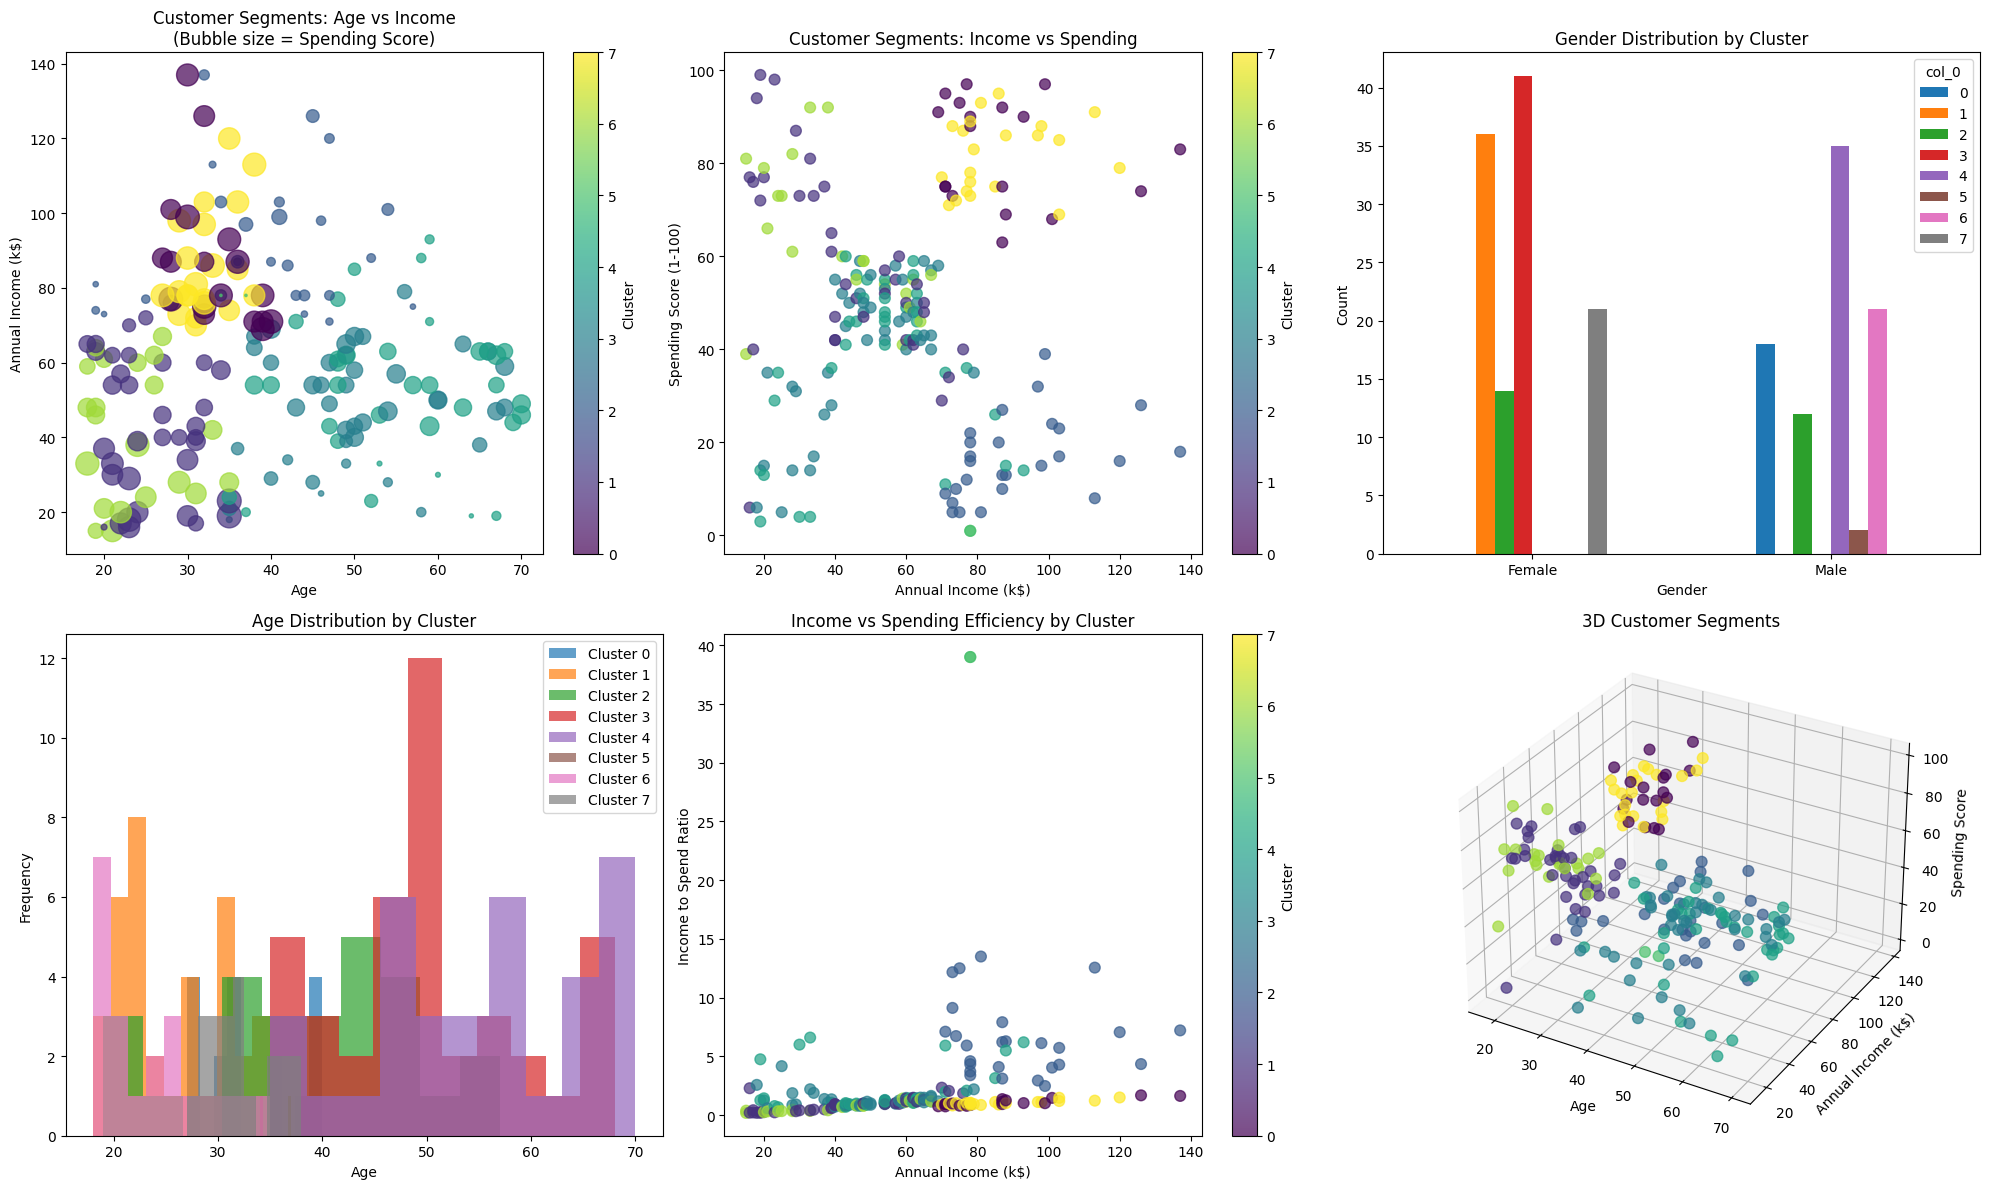

In [20]:
# Let's create beautiful visualizations to showcase our discovered customer segments
# We'll use our best performing model to create actionable business insights

# First, let's get predictions from our best K-means model
best_k = optimal_k  # Using the optimal k we found earlier
final_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans_labels = final_kmeans.fit_predict(X_scaled)

# Create comprehensive visualizations of our customer segments
plt.figure(figsize=(20, 12))

# Subplot 1: Age vs Annual Income (showing spending behavior through color)
plt.subplot(2, 3, 1)
scatter = plt.scatter(df_clean['Age'], df_clean['Annual Income (k$)'], 
                     c=kmeans_labels, cmap='viridis', 
                     s=df_clean['Spending Score (1-100)'] * 3, alpha=0.7)
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')
plt.title('Customer Segments: Age vs Income\n(Bubble size = Spending Score)')
plt.colorbar(scatter, label='Cluster')

# Subplot 2: Annual Income vs Spending Score (classic customer segmentation view)
plt.subplot(2, 3, 2)
scatter = plt.scatter(df_clean['Annual Income (k$)'], df_clean['Spending Score (1-100)'], 
                     c=kmeans_labels, cmap='viridis', s=60, alpha=0.7)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('Customer Segments: Income vs Spending')
plt.colorbar(scatter, label='Cluster')

# Subplot 3: Gender distribution across clusters
plt.subplot(2, 3, 3)
gender_cluster = pd.crosstab(df_clean['Gender'], kmeans_labels)
gender_cluster.plot(kind='bar', ax=plt.gca())
plt.title('Gender Distribution by Cluster')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Subplot 4: Age distribution by cluster
plt.subplot(2, 3, 4)
for cluster in range(best_k):
    cluster_ages = df_clean[kmeans_labels == cluster]['Age']
    plt.hist(cluster_ages, alpha=0.7, label=f'Cluster {cluster}', bins=10)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution by Cluster')
plt.legend()

# Subplot 5: Income vs our engineered feature (Income_to_Spend ratio)
plt.subplot(2, 3, 5)
scatter = plt.scatter(df_clean['Annual Income (k$)'], df_features['Income_to_Spend'], 
                     c=kmeans_labels, cmap='viridis', s=60, alpha=0.7)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Income to Spend Ratio')
plt.title('Income vs Spending Efficiency by Cluster')
plt.colorbar(scatter, label='Cluster')

# Subplot 6: 3D visualization (Age, Income, Spending Score)
ax = plt.subplot(2, 3, 6, projection='3d')
ax.scatter(df_clean['Age'], df_clean['Annual Income (k$)'], df_clean['Spending Score (1-100)'], 
          c=kmeans_labels, cmap='viridis', s=60, alpha=0.7)
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score')
ax.set_title('3D Customer Segments')

plt.tight_layout()
plt.show()

In [22]:
# Create detailed cluster profiles for business insights
# This is where our technical analysis becomes actionable business intelligence

print("\n" + "="*80)
print("CUSTOMER SEGMENT PROFILES - BUSINESS INSIGHTS")
print("="*80)

for cluster in range(best_k):
    cluster_data = df_features[kmeans_labels == cluster]
    print(f"\n🎯 CLUSTER {cluster} PROFILE (n={len(cluster_data)} customers)")
    print("-" * 50)
    
    # Demographic summary - understanding who our customers are
    print(f"📊 Demographics:")
    print(f"   • Average Age: {cluster_data['Age'].mean():.1f} years")
    print(f"   • Gender Split: {cluster_data['Gender'].value_counts().to_dict()}")
    
    # Financial behavior - understanding their purchasing power and habits
    print(f"💰 Financial Profile:")
    print(f"   • Average Income: ${cluster_data['Annual Income (k$)'].mean():.1f}k")
    print(f"   • Average Spending Score: {cluster_data['Spending Score (1-100)'].mean():.1f}/100")
    print(f"   • Income-to-Spend Ratio: {cluster_data['Income_to_Spend'].mean():.2f}")
    
    # Business interpretation - categorizing segment characteristics
    income_level = "High" if cluster_data['Annual Income (k$)'].mean() > df_features['Annual Income (k$)'].mean() else "Low"
    spending_level = "High" if cluster_data['Spending Score (1-100)'].mean() > df_features['Spending Score (1-100)'].mean() else "Low"
    
    print(f"🏷️  Segment Type: {income_level} Income, {spending_level} Spending")
    
    # Marketing recommendations based on segment characteristics
    if income_level == "High" and spending_level == "High":
        recommendation = "Premium products, luxury experiences, VIP programs"
    elif income_level == "High" and spending_level == "Low":
        recommendation = "Value propositions, savings programs, quality focus"
    elif income_level == "Low" and spending_level == "High":
        recommendation = "Budget-friendly options, payment plans, discounts"
    else:
        recommendation = "Basic products, competitive pricing, essential needs"
    
    print(f"💡 Marketing Strategy: {recommendation}")

# Summary of algorithm performance comparison
print("\n" + "="*80)
print("ALGORITHM PERFORMANCE SUMMARY")
print("="*80)
print(f"🏆 Best K-means Configuration: k={optimal_k}")
print(f"   • Silhouette Score: {results_df[results_df['k']==optimal_k]['silhouette'].iloc[0]:.3f}")
print(f"   • Davies-Bouldin Index: {results_df[results_df['k']==optimal_k]['davies_bouldin'].iloc[0]:.3f} (lower is better)")
print(f"   • Calinski-Harabasz Index: {results_df[results_df['k']==optimal_k]['calinski_harabasz'].iloc[0]:.1f} (higher is better)")

print(f"\n🌳 Best Hierarchical Configuration: {better_linkage} linkage")
print(f"   • Cophenetic Correlation: {better_correlation:.3f}")

print(f"\n📊 Statistical Validation:")
print(f"   • Numeric features show significant cluster differences (p < 0.05)")
print(f"   • Gender distribution varies significantly across clusters")
print(f"   • Age groups show distinct clustering patterns")


CUSTOMER SEGMENT PROFILES - BUSINESS INSIGHTS

🎯 CLUSTER 0 PROFILE (n=18 customers)
--------------------------------------------------
📊 Demographics:
   • Average Age: 33.3 years
   • Gender Split: {'Male': 18}
💰 Financial Profile:
   • Average Income: $87.1k
   • Average Spending Score: 82.7/100
   • Income-to-Spend Ratio: 1.06
🏷️  Segment Type: High Income, High Spending
💡 Marketing Strategy: Premium products, luxury experiences, VIP programs

🎯 CLUSTER 1 PROFILE (n=36 customers)
--------------------------------------------------
📊 Demographics:
   • Average Age: 25.7 years
   • Gender Split: {'Female': 36}
💰 Financial Profile:
   • Average Income: $42.8k
   • Average Spending Score: 58.1/100
   • Income-to-Spend Ratio: 0.90
🏷️  Segment Type: Low Income, High Spending
💡 Marketing Strategy: Budget-friendly options, payment plans, discounts

🎯 CLUSTER 2 PROFILE (n=26 customers)
--------------------------------------------------
📊 Demographics:
   • Average Age: 39.0 years
   • Gender